# Wallet Hub Data Scientist Test Modeling Project
## Aiden V. Johnson
## December 17, 2018
---
This notebook is the working document that was used for the development of the prediction model. 

---
## Overview

#### Goal: Create a model to predict the target variable y values.

#### Data Sources: A csv file containing 100,000 rows and 304 labeled features:x001 to x304

#### Modeling Response: y values

#### Classification or Regression Model: Regession

#### Model Evaluation metrics: RMSE

#### Deliverables:
1. A model report 
2. Code used in model development
3. Instructions to run the production model + Model file to load
---

In [1]:
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
import os
#os.listdir()

In [2]:
file="dataset_00_with_header.csv"
df=pd.read_csv(file)
print(df.shape)
#df.isnull().sum().sort_values(ascending=False)
df=df.dropna(axis=1)
print(df.shape)

(100000, 305)
(100000, 264)


In [3]:
#df.describe().T

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
y=df['y'].values
sc = StandardScaler()
X=sc.fit_transform(df.drop(['y'], axis=1).values)

/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


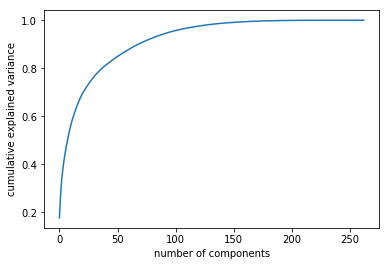

In [5]:
from sklearn.decomposition import PCA
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [6]:
from sklearn.decomposition import PCA
pca = PCA(.95)

In [7]:
#split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [8]:
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [9]:
train_pca = pca.transform(X_train)
test_pca = pca.transform(X_test)

In [10]:
np.shape(train_pca)

(70000, 96)

In [11]:
train_plus=np.concatenate((X_train,train_pca),axis=1)
test_plus=np.concatenate((X_test,test_pca),axis=1)

## Find optimal alpha for Lasso Regression through CV testing

In [12]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from math import sqrt
#alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]

#val_errors = []
#for alpha in alphas:
#    lasso = Lasso(alpha=alpha, fit_intercept=True, random_state=77)
#   errors = np.sum(-cross_val_score(lasso,train_plus, y=y_train,
#   scoring='neg_mean_squared_error', cv=10, n_jobs=-1))
#   val_errors.append(np.sqrt(errors))

In [13]:
#print('best alpha: {}'.format(alphas[np.argmin(val_errors)]))

In [14]:
np.shape(test_plus)

(30000, 359)

In [15]:
#Fit the model
lassoreg = Lasso(alpha=0.01,normalize=True, max_iter=1e5)
lassoreg.fit(train_plus,y_train)
y_pred = lassoreg.predict(test_plus)
rmse = sqrt(mean_squared_error(y_test, y_pred))
rmse

57.47752920072126

## Find optimal Random Forest Regressor tuning via grid search

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#param_grid = {"n_estimators": [200, 500],
#  "max_depth": [3, None],
#   "max_features": [1, 3, 5, 10],
#   "min_samples_split": [2, 5, 10],
#   "min_samples_leaf": [1, 3, 10],
#   "bootstrap": [True, False]}

#model = RandomForestRegressor(random_state=0)
#grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
#grid.fit(X_train, y_train)

#print(grid.best_score_)
#print(grid.best_params_)

In [17]:
regressor = RandomForestRegressor(random_state=0, n_estimators=200, max_depth=None, max_features=10, 
                                  min_samples_leaf=1, min_samples_split=5, bootstrap=False)
regressor.fit(train_plus, y_train)
regressor.score(test_plus, y_test)

0.93118982685209029

In [18]:
# Predicting a new result
y_pred = regressor.predict(test_plus)
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(y_test, y_pred))
rmse

31.093016769136145

Based on root mean squared error the random forest is the better model choice.

## Review the absolute error counts and distribution of the errors

In [19]:
#j=np.abs(y_pred-y_test)>=3

In [20]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, y_pred)

22.661406458333332

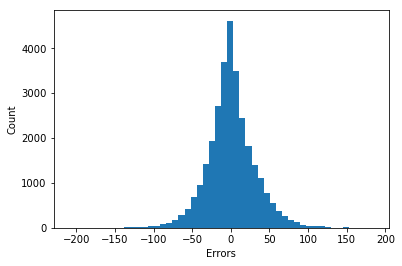

In [21]:
plt.hist(y_pred-y_test, bins = 50)
plt.xlabel("Errors")
_ = plt.ylabel("Count")

Errors cover a wider range of values than is preferred. 

## After selecting the random forest model we rebuild it using all the available input data for training

In [22]:
train_pca = pca.transform(X)
train_plus=np.concatenate((X,train_pca),axis=1)

In [23]:
regressor = RandomForestRegressor(random_state=0, n_estimators=200, max_depth=None, max_features=10, 
                                  min_samples_leaf=1, min_samples_split=5, bootstrap=False)
regressor.fit(train_plus, df.y)
regressor.score(train_plus, df.y)

0.99905051022991165

## Save the random forest model out as a loadable object for later

In [24]:
import pickle
s = pickle.dumps(regressor)
from joblib import dump, load
dump(regressor, 'rf_model.joblib') 

['rf_model.joblib']